# 内容提要

- 神经网络: 原理与实现
  - 从神经元到神经网络
  - 反向传播与模型训练
- 用`PyTorch`搭建并训练神经网络
  - 用`Lightning`简化你的代码
  - 数据的处理
  - 模型的搭建
  - 模型的训练与评估
- 卷积神经网络 (CNN): 归纳偏置 (inductive bias) 的应用
  - 卷积层
  - 池化层
  - LeNet模型
- 超参数优化
  - 完整的工作流
  - 用`Optuna`管理超参数优化

# 神经网络: 原理与实现

$\quad$神经网络 (neural networks) 是 **模型联结主义** (model connectionism) 的典型例子, 将若干个 **神经元** (neuron, 可以理解为最基本的决策单元) 按照指定方式组合起来, 实现一个可训练的学习器, 用于学习 **数据表示** (data representation).

$\quad$对于输入的特征$\mathbf{x}$, 机器学习总是试图找到一个(参数化的)非线性变换$\phi(\mathbf{x}; \mathbf{w})$, 或说 **表示** (representation), 使得数据样本在变换后的新空间中的分布结构更有利于问题的解决. 例如: 分类问题希望在新的表示下, 分属不同类别的样本点之间存在清晰的决策平面. 为此,
- 传统统计学习模型多数采取“手工设计非线性变换”的策略;
- 以神经网络为基础的**深度学习**(deep learning)则选择了另一条道路: **从数据自身学习表示(或变换)**. 这将更少地依赖专家知识, 也更利于复杂问题的建模与预测; 但弊端也是显然的: 模型性能将高度依赖训练所用的数据.

## 从神经元到神经网络

$\quad$一个最基本的神经元对输入的特征$\mathbf{x}$依次进行如下两步的处理:
- 线性变换(或说, **仿射变换**, affine transformation):
  $$
  z = \mathbf{w}^\mathrm{T}\mathbf{x} + b;
  $$
- 非线性**激活函数**(activation function)的作用:
  $$
  a = h(z).
  $$

而将若干神经元组织成一层(layer)、将若干层组织成网络, 就得到一般意义下的**全连接神经网络**(fully-connected neural network, FCNN). 若将数据集写成矩阵$\mathbf{X} \in \mathbb{R}^{N \times M}$($N$为样本数, $M$为特征数), 则FCNN的表达式可以(递归地)写为

$$\begin{aligned}
\mathbf{H}^{(l)} &= h^{(l)}(\mathbf{H}^{(l-1)}\mathbf{W}^{(l)} + \mathbf{b}^{(l)}), l = 1,\dots,L,\\
\mathbf{H}^{(0)} &\equiv \mathbf{X}.
\end{aligned}$$
其中, $L$代表神经网络的层数(也常称为**深度**), $h^{(l)}$为第$l$层的激活函数, $\mathbf{W}^{(l)} \in \mathbb{R}^{d_{l-1} \times d_l}, b^{(l)} \in \mathbb{R}$分别为第$l$层的**权重**(weights)与**偏置**(bias, 也就是截距). 这里我们将第$l$层的宽度记为$d_l$, 而$d_0 \equiv M$. 习惯上, $l=0$层称为输入层; $l=L$层称为输出层.

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/d42378dabc704d52a9962cf1a4103494/16aNid5FU9LPCXyDrrpDPw.png)

$\quad$注意到, 神经网络的层与层之间总是以非线性的激活函数隔开, 这是相当必要的. (思考: 如果不增设非线性激活, 会导致什么问题?)

## 自动微分与模型训练

$\quad$当神经网络结构变得复杂时, 损失函数的梯度计算将十分繁琐😇, 从而使损失函数的数值优化变得困难. 所以, 我们需要考虑自动化的梯度计算流程, 这常称为 **自动微分** (automatic differentiation, autodiff) 技术.

- 深度学习模型结构可以非常灵活, 所以深度学习库一般只提供模型搭建和训练所需的各种 "砌块", 以及一些经典文献中的模型. 诸如[`TensorFlow`](https://www.tensorflow.org/)、[`PyTorch`](https://pytorch.org/)等开源库往往习惯称为 **深度学习框架** (deep learning frameworks).

- 现代深度学习框架中采取的自动微分技术基于 **计算图** (computational graph) 的构建与回溯, 这比传统的 **反向传播** (backward propagation, backprop) 更加灵活高效. 篇幅所限, 我们不会详述这两种算法的细节.

- 在`PyTorch`中, 一切数值运算的基础数据结构为[`Tensor`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor). 如果其类属性`requires_grad`的值为`True`, 则我们在自动微分过程中就可以计算出损失函数$\mathcal{L}$ (或其它被微分的变量/函数) 对该`Tensor`的梯度值, 存储在类属性`grad`中, 以备数值优化或其它需要.

# 用`PyTorch`与`Lightning`搭建并训练神经网络

$\quad$本节以MNIST (Modified National Institute of Standards and Technology database) 数据集为例, 演示如何使用`PyTorch`进行神经网络模型工作流的搭建. 总体流程仍然包括: (1) **处理数据**, 使其能被接受为神经网络模型的输入; (2) **搭建模型**; (3) **训练与评估**. 只不过, 神经网络模型更加模块化.

$\quad$MNIST数据集是用于[手写数字识别](http://yann.lecun.com/exdb/mnist/)任务的一个十分经典的数据集, 我们希望所训练的神经网络模型能够较好地根据手写数字图片预测其代表的是0~9这10个数字中的哪一个. 我们调用[`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#mnist)可以很方便地实现数据集的加载与下载.
- 训练集共有60000个样本, 测试集有10000个;
- 特征是28x28大小的灰度像素矩阵, 每个矩阵元都取0~255上的一个整数值, 数值越大代表颜色越黑(越深);
- 标签是0~9范围内的整数, 代表手写字迹对应的真实数字.

$\quad$我们构建一个10类别 ($c=10$) 的SoftMax回归模型, 以一个两层的神经网络模型作为特征变换函数$f(\cdot)$, 并以负对数似然(NLL)作为损失函数. 即
$$\begin{aligned}
\mathbf{y} &= \mathrm{SoftMax}(f_{\boldsymbol{\theta}}(\mathbf{x})),\\
\mathcal{L}(\mathbf{t}, \mathbf{y}; \boldsymbol{\theta}) &= -\sum_{n=1}^N{\mathbf{t}^{(n)}\cdot\log{\mathbf{y}^{(n)}}},
\end{aligned}$$

并完成模型的训练与评估.


## 用`Lightning`简化你的代码

$\quad$我们将使用[`Lightning`](https://lightning.ai/docs/pytorch/stable/)来组织我们的`PyTorch`代码, 使之更加结构化、更易扩展到更大量级的计算资源上.

$\quad$深度学习框架的一般结构包括: **模型** + **数据** + **训练配置**. 在`Lightning`中, 我们需要定义:
- 一个数据模块基类[`LightningDataModule`](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.LightningDataModule.html#lightning.pytorch.core.LightningDataModule)的派生类, 用于定义初始数据的下载/读取、数据清洗、数据加载等任务流程.   
- 一个模型基类[`LightningModule`](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.LightningModule.html#lightningmodule)的派生类, 用于定义模型结构、损失函数等.
- 一个模型训练器[`Trainer`](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer)的对象, 用于定义各种训练配置、超参数等.

## 数据处理与可视化

$\quad$我们用[`torchvision`](https://pytorch.org/vision/0.9/)完成图像数据的预处理. 这是一个涵盖了常用的计算机视觉相关的(模型、数据、变换操作等元素的)深度学习库, 它将常见的图像变换处理操作(例如数据类型转换、特征归一化等等)封装在了[`torchvision.transforms`](https://pytorch.org/vision/0.9/transforms.html#torchvision-transforms)模块. 我们首先下载MNIST数据集, 并对数据集作如下一系列的变换:
- **数据类型转换**. 起初, 特征储存为[`PIL.Image.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image)格式, 我们用[`ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#totensor)将其转换为[`Tensor`](https://pytorch.org/docs/stable/tensors.html#torch-tensor)格式.
- **特征归一化**. 这里, 我们以[`Normalize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#normalize)进行均值-方差归一化操作. 我们将参数`mean`和`std`直接提供给大家: 分别为0.1307和0.3081.
- 以上两步变换可由[`Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#compose)很方便地 **组装起来**, 作为`transform`参数传入MNIST数据集的构造函数[`MNIST()`](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

$\quad$我们同时定义`visualize_train_data()`方法对训练样本进行可视化 (初步探索).
- 当对数据集进行索引操作时, 我们将得到一个二元元组, 分别为特征和标签.
  - 每个样本的特征的形状是`(1, 28, 28)`, 后两个维度为像素值, 而第一个维度是图片的 **色彩通道** (channel).
  - 由于MNIST图像都是灰度图, 所以只有1个通道; 而在常用的三通道色彩空间RGB或[YUV](https://dexonsystems.com/blog/rgb-yuv-color-spaces)中, 通道维度的大小为3.
  - 注意需要对`Tensor`做[`squeeze()`](https://pytorch.org/docs/stable/generated/torch.squeeze.html#torch-squeeze)处理, 将 (值为1的) 通道维度 "挤压" 掉, 得到二维数组, 便于灰度图的绘制.

In [1]:
import lightning as L
import os
import torch
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

class MNISTDataModule(L.LightningDataModule):
    def __init__(self, batch_size: int=64):
        super().__init__()
        mean, std = 0.1307, 0.3081
        self.batch_size = batch_size
        self.transform = Compose([ToTensor(), Normalize((mean, ), (std, ))])
    def prepare_data(self):
        _ = MNIST(root=os.getcwd(), train=True, download=True)
        _ = MNIST(root=os.getcwd(), train=False, download=True)
    def setup(self, stage: str):
        match stage:
            case 'fit':
                mnist_train_val = MNIST(root=os.getcwd(), transform=self.transform, train=True)
                self.mnist_train, self.mnist_val = random_split(
                    mnist_train_val, [55000, 5000], generator=torch.Generator().manual_seed(42)
                )
            case 'test':
                self.mnist_test = MNIST(root=os.getcwd(), transform=self.transform, train=False)
    def visualize_train_data(self, n_samples: int=20, n_rows: int=2):
        from matplotlib import pyplot as plt
        samples = [self.mnist_train[i] for i in range(n_samples)]
        plt.figure(figsize=(10, 3))
        for i, sample in enumerate(samples):
            img, label = sample
            plt.subplot(n_rows, n_samples // n_rows, i + 1)
            # squeeze the channel dimension
            plt.imshow(img.squeeze().numpy(), cmap="gray", interpolation="none")
            plt.title(f"label: {label}")
            plt.axis("off")
        plt.show()

In [2]:
datamodule = MNISTDataModule()
datamodule.prepare_data()
datamodule.setup(stage='fit')

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.23MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 124kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.06MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.92MB/s]


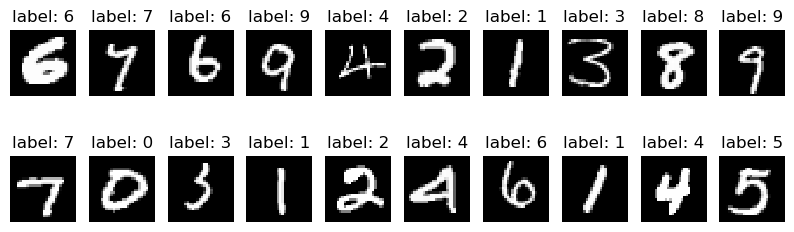

In [3]:
datamodule.visualize_train_data()

$\quad$实践经验表明, 一种比较高效的遍历训练数据的方法是: 将训练数据分作若干**批次** (batch), 并在每个批次上进行损失函数的 (约化值, 例如均值、总和等) 计算与参数的更新. 基本理念是: **用少量数据上算出的、富于噪声的、程度更小的更新步, 代替全体数据上算出的、小噪声的、程度更大的更新步**.

- 批次划分的操作可以用[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)很方便地完成, 我们用参数`batch_size`指定单批次的样本大小.
- 所获得的`DataLoader`对象本质是一个迭代器, 可以遍历各个数据批次, 每个数据批次的特征和标签都被“打包”成新的`Tensor`.
- 遍历`DataLoader`时, 每个批次的数据 ("打包"的`Tensor`) 都在第1个维度以左新增一个维度, 用以代指单条样本在该批次中的索引, 这是batch-first的数据组织格式, 为`PyTorch`所默认.
  - Batch-first格式的优点是方便 **向量化** (vectorization), 因为矩阵运算总是对最末维度进行的, 在最左侧进行"升维"无非是平行地将矩阵运算"复制"若干份.

In [4]:
from torch.utils.data import DataLoader

class MNISTDataModule(MNISTDataModule):
    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=3)
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.mnist_val, batch_size=len(self.mnist_val), num_workers=3)
    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.mnist_test, batch_size=len(self.mnist_test), num_workers=3)

In [5]:
batch_size = 64

datamodule = MNISTDataModule(batch_size=batch_size)
datamodule.prepare_data()
datamodule.setup(stage='fit')

it = iter(datamodule.train_dataloader())
X_first_batch, y_true_first_batch = next(it)
X_first_batch.size(), y_true_first_batch.size()

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

## 神经网络模型的搭建



$\quad$如前所述, 深度学习框架往往只提供最基本的"操作单元", 需要由用户按照自己的设计将它们组装起来, 编写一个[`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#module)的子类作为模型模块. 在编写子类时, 至少需要实现如下两个方法:
- 初始化`__init__()`, 定义神经网络模型的层和相关的组件参数.
- 前向传播`forward`, 定义输入数据`X`的前向计算过程.

`PyTorch`将在训练过程中根据`forward()`方法所定义的"前向"传播过程构建一张 **计算图** (computational graph), 以[`backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html#torch.Tensor.backward)方法自动化地处理反向传播计算.

$\quad$我们先以一个`SoftMaxMLP`模型作为示例. 以下是模型架构的示意图:

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/dea2dc5cd1344775983d68bdbbcd3b65/CVWlcOgo5a9p4jxkWe5Z4Q.png)


该模型的输入层接受28x28=784个特征 (由于MLP的局限性, 我们不得不稍后将二维图像“压扁”成一维向量作为输入), 输出层给出10个输出值, 经由SoftMax激活后解释为概率. 涉及到的计算组件包括:
- 线性操作层[`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), 对数据施加线性变换;
- ReLU函数激活[`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU);
- 输出层的 (对数-) SoftMax激活[`nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax). 这一方法在`PyTorch`中相比于SoftMax而言具有更好的数值稳定性, 与损失函数[`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)是配合使用的.

这里, 每个组件都是一个对象, 实现前向传播时只需把它当成函数、直接调用即可 (实质相当于调用`__call__`方法), 例如:
```python
linear = nn.Linear()
X_out = linear(X_in)
```

In [6]:
from torch import nn

class SoftMaxMLP(nn.Module):
    def __init__(self, num_inputs=784, num_hiddens=32, num_outputs=10):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.hidden_activation = nn.ReLU()
        self.fc2 = nn.Linear(num_hiddens, num_outputs)
        self.output_activation = nn.LogSoftmax(dim=-1)
    def forward(self, X):
        # Note: the raw input data will be a 4-D tensor in size (batch_size, num_channels, height, weight),
        # but the data applicable to the SoftMaxMLP should be in size (batch_size, num_features).
        return self.output_activation(self.fc2(self.hidden_activation(self.fc1(X))))

$\quad$对模型调用`print()`函数, 可以大致检查各层的输入维度、输出维度. 可以[戳这里](https://alexlenail.me/NN-SVG/)进行神经网络可视化的绘制.

In [7]:
softmax_mlp = SoftMaxMLP()
print(softmax_mlp)

SoftMaxMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (hidden_activation): ReLU()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (output_activation): LogSoftmax(dim=-1)
)


$\quad$随后, 我们将模型整体封装为`LightningModule`的派生类, 并
- 以`training_step()`方法计算训练步骤中的模型输出与损失函数, 并最终将 (约化好的) 损失函数返回;
- 以`validation_step()`方法定义验证 (以及超参数调优) 步骤的模型行为, 以`test_step()`方法定义测试步骤的模型行为.

In [8]:
from torchmetrics import Accuracy, ConfusionMatrix
from typing import Tuple

class LitSoftMaxMLP(L.LightningModule):
    def __init__(self, num_inputs: int=784, num_hiddens: int=32, num_outputs: int=10, lr: float=0.001):
        super().__init__()
        self.softmax_mlp = SoftMaxMLP(num_inputs=num_inputs, num_hiddens=num_hiddens, num_outputs=num_outputs)
        self.lr = lr
        self.loss_fn = nn.NLLLoss(reduction='mean')
        self.accuracy = Accuracy(task='multiclass', num_classes=num_outputs)
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        X_flattened, y_true = self._flatten_data(batch)
        y_output = self.softmax_mlp(X_flattened)
        loss = self.loss_fn(y_output, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    def validation_step(self, batch, batch_idx):
        X_flattened, y_true = self._flatten_data(batch)
        y_output = self.softmax_mlp(X_flattened)
        y_pred = y_output.argmax(dim=-1)
        acc = self.accuracy(y_pred, y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
    def test_step(self, batch, batch_idx):
        X_flattened, y_true = self._flatten_data(batch)
        y_output = self.softmax_mlp(X_flattened)
        y_pred = y_output.argmax(dim=-1)
        acc = self.accuracy(y_pred, y_true)
        self.log('test_acc', acc)
    def _flatten_data(self, batch) -> Tuple[torch.Tensor, torch.Tensor]:
        X, y_true = batch
        X_flattened = X.view(X.size(0), -1)
        return X_flattened, y_true

## 模型的训练与评估



$\quad$根据给定的训练数据集$\mathcal{D}$, 我们就可以利用特定的数值优化算法$\mathcal{O}$对参数$\mathbf{W}$进行更新. 这些优化算法多数基于损失函数梯度, 即

$$
\mathbf{W}':=\mathcal{O}\left(\mathbf{W}, \nabla\mathcal{L}(\mathbf{W};\mathcal{D})\right).
$$

在模型训练过程中, 我们将迭代地遍历训练数据, 并利用封装在[`torch.optim`](https://pytorch.org/docs/stable/optim.html#module-torch.optim)模块的特定**优化器** (optimizer) $\mathcal{O}$进行参数更新. 在`Lightning`中, 这些流程将被自动化地执行, 我们只需要定义在训练、验证、测试各阶段需要 **记录** (log) 的实验参数与结果.
- 我们一般建议使用[`Adam`](https://arxiv.org/abs/1412.6980)优化器, 其优点在于对不同架构模型的训练任务非常稳健.
- 优化器及相关参数需要在`LightningModule`中以`configure_optimizers()`方法给出.

In [9]:
from torch import optim

class LitSoftMaxMLP(LitSoftMaxMLP):
    def configure_optimizers(self) -> optim.Optimizer:
        return optim.Adam(self.softmax_mlp.parameters(), self.lr)

$\quad$随后, 我们构建训练器[`Trainer`](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer)的对象, 并调用`fit()`方法进行模型训练.

In [10]:
from lightning.pytorch.loggers import CSVLogger
from torch.utils.data import DataLoader

model_config = {
    "num_hiddens": 32,
    "lr": 0.01
}
data_config = {"batch_size": 512}

softmax_mlp = LitSoftMaxMLP(**model_config)
datamodule = MNISTDataModule(**data_config)
logger = CSVLogger(save_dir='./nn', name='softmaxmlp_train_demo')
trainer = L.Trainer(max_epochs=5, logger=logger, accelerator='auto')
trainer.fit(model=softmax_mlp, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | softmax_mlp | SoftMaxMLP         | 25.4 K | train
1 | loss_fn     | NLLLoss            | 0      | train
2 | accuracy    | MulticlassAccuracy | 

Epoch 4: 100%|██████████| 108/108 [00:01<00:00, 65.23it/s, v_num=0]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 108/108 [00:01<00:00, 64.93it/s, v_num=0]


In [11]:
import pandas as pd
metrics = pd.read_csv('nn/softmaxmlp_train_demo/version_0/metrics.csv')
train_loss = metrics['train_loss'].dropna()
val_acc = metrics['val_acc'].dropna()
train_loss, val_acc

(1    0.378098
 3    0.182858
 5    0.150938
 7    0.132825
 9    0.119629
 Name: train_loss, dtype: float64,
 0    0.9312
 2    0.9420
 4    0.9486
 6    0.9456
 8    0.9444
 Name: val_acc, dtype: float64)

# 卷积神经网络 (CNN): 归纳偏置 (inductive bias) 的应用



$\quad$看起来, 我们已经取得了不错的预测效果😜! 不过, 图像毕竟是一种 **结构化的数据** (structured data). 在许多更复杂的任务中,
- 直接"压扁"为一维向量输入MLP的做法并不能取得令人满意的效果, 因为这丢失了图像数据在空间上的结构信息.
- 如果训练数据量不够, 则纯粹的、不引入任何先验知识的MLP模型往往对有效信息的提取规律十分有限.

$\quad$现实世界的图像信息往往具有两条基本规律:
- **平移等变性** (translational equivariance): 相机镜头的平动会引起对应信息的同样程度的平动. 当图像输入$\mathbf{X}$的下标平移时, 对应的隐藏层表示也会发生相同的平移.
- **局域性** (locality): 与某像素相关的信息不会离它很远. 所以, 隐藏层表示的某个分量只需包含进它附近的信息就足够了.

基于这两条假设, 我们就不必再对输入的图像$\mathbf{X} \in \mathbb{R}^{H \times W}$作一个(四维的)张量积运算
$$
\mathbf{H}_{i,j} = \sum_k{\sum_l{\mathsf{W}_{i,j,k,l}\mathbf{X}_{k,l}}},
$$
而是可以简化成一个 **互相关** (cross-correlation) 运算, 或 **卷积** (convolution) 运算:
$$
\mathbf{H}_{i,j} = \sum_{a = -\delta_a}^{\delta_a}{\sum_{b=-\delta_b}^{\delta_b}{\mathbf{V}_{a,b}\mathbf{X}_{i+a, j+b}}}.
$$

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/d32858adbcbe4a2d83f0b8e350beb23c/ttk2YrdcvLBHX2fa2TuHxg.png)

## 卷积层



$\quad$(二维) 卷积操作层在`PyTorch`中定义为[`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).
- 它的输入数据是一个四维张量, 各个维度依次代表:
  - $N$, 批次大小 (batch size).
  - $C_\mathrm{in}$, 输入数据的通道数. 卷积运算在各个通道上是独立进行的. 其中, 输入数据的通道数和输出数据的通道数分别由参数`in_channels`和`out_channels`指定.
  - $H$与$W$, 图片的高度 (行数) 和宽度 (列数).
- 每个输入-输出通道对都对应一个 **卷积核** (convolution kernel) $\mathbf{V}$, 其大小由参数`kernel_size`指定, 各个分量作为可训练参数用于模型训练.
- 还可以设置各种操作细节. 例如:
  - 图片边缘的 **补零** (padding), 以充分提取原图片的边界信息. 补齐方式由参数`padding`指定, 默认为0 (不补零).
  - 卷积核的滑动 **步长** (striding), 以更快速地实现 **降采样** (sub-sampling). 滑动步长由参数`stride`指定, 默认为1 (每次移动1步).
  - 卷积核的 **扩张** (dilation), 以使提取的信息更加广域, 扩张方式由参数`dilation`指定, 默认为1 (不扩张卷积核, 相邻分量下标间距为1).

## 池化层

$\quad$池化 (pooling) 操作是一种具有局部平移不变性的降采样技术. 实践中一般推荐使用 **最大池化** (max pooling). `PyTorch`的二维池化层定义为[`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).
- 它的输入数据格式与卷积层的输入数据格式一致.
- 池化层不含任何可训练参数, 池化核 (或窗口) 的大小由参数`kernel_size`指定.
- 它同样可以设置`padding`、`striding`和`dilation`等操作细节, 意义与卷积层的对应参数相同.

## LeNet模型

$\quad$Yann LeCun发展了基于卷积神经网络的手写数字识别模型[LeNet](https://ieeexplore.ieee.org/document/726791/), 其架构如下图所示:

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/0fb23255d1f94a6681677cc9630dda2f/7yPMrEkxWeWJJwmVZf6LIQ.png)

我们给出对应的代码实现.

In [12]:
class LeNet5Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pooling1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pooling2 = nn.AvgPool2d(kernel_size=2, stride=2)
    def forward(self, X):
        X = self.pooling1(torch.tanh(self.conv1(X)))
        X = self.pooling2(torch.tanh(self.conv2(X)))
        return X

class LeNet5FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcnn = nn.Sequential(
            nn.Linear(5 * 5 * 16, 120), nn.Tanh(), nn.Linear(120, 84), nn.Tanh(), nn.Linear(84, 10)
        )
        self.output_activation = nn.LogSoftmax(dim=-1)
    def forward(self, X) -> torch.Tensor:
        return self.output_activation(self.fcnn(X))

In [13]:
class LeNet5(L.LightningModule):
    def __init__(self, conv_net, fc_net, lr: float=0.001):
        super().__init__()
        self.conv_net = conv_net
        self.fc_net = fc_net
        self.lr = lr
        self.loss_fn = nn.NLLLoss(reduction='mean')
        self.accuracy = Accuracy(task='multiclass', num_classes=10)
        self.confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=10)
    def forward(self, X) -> torch.Tensor:
        return self.fc_net(self.conv_net(X).view(X.size(0), -1))
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        X, y_true = batch
        y_output = self.forward(X)
        loss = self.loss_fn(y_output, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    def validation_step(self, batch, batch_idx):
        X, y_true = batch
        y_output = self.forward(X)
        y_pred = y_output.argmax(dim=-1)
        acc = self.accuracy(y_pred, y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
    def test_step(self, batch, batch_idx):
        X, y_true = batch
        y_output = self.forward(X)
        y_pred = y_output.argmax(dim=-1)
        confusion_matrix = self.confusion_matrix(y_pred, y_true)
        self.log('confusion_matrix', confusion_matrix, on_step=False, on_epoch=True)
    def configure_optimizers(self) -> optim.Optimizer:
        return optim.Adam(self.parameters(), lr=self.lr)

In [14]:
lenet5_conv = LeNet5Conv()
lenet5_fcnn = LeNet5FCNN()
lenet = LeNet5(lenet5_conv, lenet5_fcnn)
print(lenet)

LeNet5(
  (conv_net): LeNet5Conv(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (pooling2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_net): LeNet5FCNN(
    (fcnn): Sequential(
      (0): Linear(in_features=400, out_features=120, bias=True)
      (1): Tanh()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): Tanh()
      (4): Linear(in_features=84, out_features=10, bias=True)
    )
    (output_activation): LogSoftmax(dim=-1)
  )
  (loss_fn): NLLLoss()
  (accuracy): MulticlassAccuracy()
  (confusion_matrix): MulticlassConfusionMatrix()
)


$\quad$我们以相似的代码完成模型训练.

In [15]:
LeNet5_model_config = {"lr": 0.01}
LeNet5_data_config = {"batch_size": 512}

lenet5 = LeNet5(lenet5_conv, lenet5_fcnn, **LeNet5_model_config)
datamodule = MNISTDataModule(**LeNet5_data_config)
logger = CSVLogger(save_dir='./nn', name='lenet5_train_demo')
trainer = L.Trainer(max_epochs=5, logger=logger, accelerator='auto')
trainer.fit(model=lenet5, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 108/108 [00:01<00:00, 62.69it/s, v_num=0]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 108/108 [00:01<00:00, 62.21it/s, v_num=0]


In [16]:
metrics = pd.read_csv('nn/lenet5_train_demo/version_0/metrics.csv')
train_loss = metrics['train_loss'].dropna()
val_acc = metrics['val_acc'].dropna()
train_loss, val_acc

(1    0.278416
 3    0.094051
 5    0.066994
 7    0.056470
 9    0.049103
 Name: train_loss, dtype: float64,
 0    0.9640
 2    0.9736
 4    0.9740
 6    0.9772
 8    0.9806
 Name: val_acc, dtype: float64)

$\quad$可以看到, 在5轮次训练后, `LeNet5`在验证集上的准确率比`SoftMaxMLP`高出约3%. 后者在深度学习项目中常称为 [**基线** (baseline)](https://censius.ai/blogs/how-to-implement-baselines-in-ml-modeling) 模型, 往往复杂度较低、预测性能不高, 我们希望所设计的新模型至少可以优于基线.

# 超参数优化

## 完整的工作流

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/0fb23255d1f94a6681677cc9630dda2f/W-blQI5JRsKUwffWgdyOZg.png)

$\quad$用伪代码表示如下.
```python
metrics = []
for config in search_space:
    metrics.append(cross_validation(train_val_dataset, config))
best_config = argbest(metrics)
final_model = train(train_val_dataset, best_config)
```
其中, 交叉验证的过程`cross_validation`已经在上机实习2中介绍, 代码块展示如下. 这里采用3折交叉验证, 并返回验证集的平均损失函数、平均准确率.
- 数据模块`MNISTDataModule`对训练集和验证集的拆分是硬编码的, 我们下面重写一个数据模块`MNISTSamplingDataModule`, 支持根据给定的数据索引`train_idx`与`val_idx`来进行训练-验证集拆分.
  - `train_idx`若为`None`, 则不拆分. 这对后续完整的模型训练非常方便.

In [17]:
from torch.utils.data import Subset
from typing import Sequence

class MNISTSamplingDataModule(L.LightningDataModule):
    def __init__(self, train_idx: Sequence[int]=None, val_idx: Sequence[int]=None, batch_size: int=64):
        super().__init__()
        mean, std = 0.1307, 0.3081
        self.batch_size = batch_size
        self.train_idx = train_idx
        self.val_idx = val_idx
        self.transform = Compose([ToTensor(), Normalize((mean, ), (std, ))])
    def prepare_data(self):
        _ = MNIST(root=os.getcwd(), train=True, download=True)
        _ = MNIST(root=os.getcwd(), train=False, download=True)
    def setup(self, stage: str):
        match stage:
            case 'fit' | 'validate':
                mnist_train_val = MNIST(root=os.getcwd(), transform=self.transform, train=True)
                if self.train_idx is not None:
                    try:
                        assert self.val_idx is not None
                        self.mnist_train = Subset(mnist_train_val, self.train_idx)
                        self.mnist_val = Subset(mnist_train_val, self.val_idx)
                    except AssertionError:
                        raise ValueError(
                            'When `train_idx` is provided, the `val_idx` should correspondingly NOT be `None`.'
                        )
                else:
                    self.mnist_train = mnist_train_val
            case 'test':
                self.mnist_test = MNIST(root=os.getcwd(), transform=self.transform, train=False)
    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.mnist_train, batch_size=self.batch_size, pin_memory=True, num_workers=3)
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.mnist_val, batch_size=len(self.mnist_val), pin_memory=True, num_workers=3)
    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.mnist_test, batch_size=len(self.mnist_test), pin_memory=True, num_workers=3)

In [18]:
from sklearn.model_selection import KFold
from typing import Dict

def cross_validation(model_config: Dict, data_config: Dict, name: str, n_splits: int=3) -> float:
    kf = KFold(n_splits=n_splits)
    accs = []
    for train_idx, val_idx in kf.split(range(60000)):
        # basic setups
        model = LeNet5(LeNet5Conv(), LeNet5FCNN(), **LeNet5_model_config)
        datamodule = MNISTSamplingDataModule(train_idx=train_idx, val_idx=val_idx, **data_config)
        logger = CSVLogger(save_dir='./nn', name=name)
        # training stage
        trainer = L.Trainer(max_epochs=5, logger=logger, accelerator='auto')
        trainer.fit(model, datamodule)
        # validation stage
        acc = trainer.validate(model, datamodule, verbose=False)[0]
        accs.append(acc['val_acc'])
    return sum(accs) / len(accs)

In [19]:
avg_acc = cross_validation(LeNet5_model_config, LeNet5_data_config, name='lenet5_cv')

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 28.94it/s, v_num=0]          

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 28.83it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 29.18it/s, v_num=1]          

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 29.03it/s, v_num=1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 32.63it/s, v_num=2]          

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 32.51it/s, v_num=2]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


In [20]:
avg_acc

0.9737499952316284

## 用`Optuna`管理超参数优化

$\quad$[`Optuna`](https://optuna.org/)是一款轻量级的 (超参数) 优化工具. 以下是用法示例:
```python
import optuna

def objective(trial):
    x = trial.suggest_float('x', -10, 10)
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}
```
- 我们定义一个目标函数`objective`, 其中:
  - 输入: `trial`, 代表单次试验[`Trial`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial). 我们可以在试验中以一系列的`suggest_`方法来定义 **超参数的搜索空间**.
  - 返回: 目标函数的值, 例如损失函数、准确率等, 作为 **优化指标**.

In [21]:
def objective(trial):
    # use log-uniform distribution for `lr`
    lr = trial.suggest_float(name='lr', low=1e-4, high=1e-1, log=True)
    # use discrete-uniform distribution for `batch_size`
    batch_size = trial.suggest_categorical(name='batch_size', choices=[32, 64, 128, 256, 512])
    # perform 3-fold cross validation
    return cross_validation(model_config={'lr': lr}, data_config={'batch_size': batch_size}, name='lenet5_tune')

In [22]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

/home/ccfrog/miniconda3/envs/mlchem/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-06 17:00:01,976] A new study created in memory with name: no-name-e6c8612f-df3b-49cb-9991-066351337874
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN               

Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 88.00it/s, v_num=0]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 87.74it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 87.06it/s, v_num=1]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 86.82it/s, v_num=1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 87.50it/s, v_num=2]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 87.14it/s, v_num=2]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

[I 2025-11-06 17:01:04,653] Trial 0 finished with value: 0.964733342329661 and parameters: {'lr': 0.000858944717908137, 'batch_size': 128}. Best is trial 0 with value: 0.964733342329661.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 107.35it/s, v_num=3]       

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 107.14it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 108.72it/s, v_num=4]       

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 108.46it/s, v_num=4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 106.81it/s, v_num=5]       

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 106.57it/s, v_num=5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

[I 2025-11-06 17:02:39,365] Trial 1 finished with value: 0.9475333293279012 and parameters: {'lr': 0.015020061153302715, 'batch_size': 64}. Best is trial 0 with value: 0.964733342329661.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 110.34it/s, v_num=6]       

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 110.10it/s, v_num=6]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 105.68it/s, v_num=7]       

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 105.41it/s, v_num=7]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | conv_net         | LeNet5Conv                | 2.6 K  | train
1 | fc_net           | LeNet5FCNN                | 59.1 K | train
2 | loss_fn          | NLLLoss                   | 0      | train
3 | accuracy         | MulticlassAccuracy        | 0      | train
4 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total

Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 106.07it/s, v_num=8]       

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 625/625 [00:05<00:00, 105.86it/s, v_num=8]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]

[I 2025-11-06 17:04:12,305] Trial 2 finished with value: 0.9502833286921183 and parameters: {'lr': 0.04870611465803168, 'batch_size': 64}. Best is trial 0 with value: 0.964733342329661.


In [23]:
study.best_params

{'lr': 0.000858944717908137, 'batch_size': 128}

$\quad$最后, 我们将全部的训练集用于最终模型的训练, 就完成任务啦😍! 我们略去这部分代码了.